
This notebook contains our first CNN without transfer learning, built on the first days of the challenge. It reached a quite good score, but seeing the results with TL we abandoned it and switched to more complicated structures. Here we are reporting only the version that we have built for Weedelec Mais, but we have built similar structures also for the other datasets.

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

We import libraries, set the seed and the working directory.

In [ ]:
import os 

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 
np.random.seed(1234)

cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We have created a folder 'Challenge2' in our drive with the dataset and the starting kit folder

In [ ]:
!unzip /content/drive/My\ Drive/Challenge2/Development_Dataset.zip 

Archive:  /content/drive/My Drive/Challenge2/Development_Dataset.zip
   creating: Development_Dataset/
  inflating: __MACOSX/._Development_Dataset  
  inflating: Development_Dataset/.DS_Store  
  inflating: __MACOSX/Development_Dataset/._.DS_Store  
   creating: Development_Dataset/Training/
  inflating: __MACOSX/Development_Dataset/._Training  
   creating: Development_Dataset/Test_Dev/
  inflating: __MACOSX/Development_Dataset/._Test_Dev  
  inflating: Development_Dataset/LICENSE.txt  
  inflating: __MACOSX/Development_Dataset/._LICENSE.txt  
  inflating: Development_Dataset/Training/.DS_Store  
  inflating: __MACOSX/Development_Dataset/Training/._.DS_Store  
   creating: Development_Dataset/Training/Roseau/
  inflating: __MACOSX/Development_Dataset/Training/._Roseau  
   creating: Development_Dataset/Training/Bipbip/
  inflating: __MACOSX/Development_Dataset/Training/._Bipbip  
   creating: Development_Dataset/Training/Pead/
  inflating: __MACOSX/Development_Dataset/Training/._Pead 

We build the generator.
We apply some augmentation because of the scarcity of data. Here we left quite a lot of transformations, while in some of the others we have found that it was better to keep just the horizontal flip or not apply any transformations.

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rescale=1./255, 
                                      rotation_range=180,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=180,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

We fix the dimensions of the images, we tried to keep it as big as possible to not lose features

In [ ]:
img_h = 1024 
img_w = 1024 

Function of the starting kit used to read the mask images with a little modification in order to do the correct reshape of the images 

In [ ]:
import os
import numpy as np
from PIL import Image


def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_img = mask_img.resize([img_h,img_w])
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    new_mask_arr=new_mask_arr.reshape((img_h,img_w,1))

    return new_mask_arr


if __name__ == "__main__":

    # Read the example RGB mask and transform it into integer labels.

    mask = read_rgb_mask("/content/drive/My Drive/Challenge2/starting_kit/predictions/rgb_mask_example.png")

    #np.save("/content/drive/My Drive/Challenge2/starting_kit/predictions/arr_mask_example.npy", mask)

Function to create the custom dataset where we read the images from the selected dataset. We have decided to focus ourselves on one dataset at a time (here Weedelec Mais)

In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=None):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'training.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'validation.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join('/content/Development_Dataset/Training/Weedelec/Mais/Images', curr_filename + '.jpg'))
    
    # Resize image and mask
    img = img.resize(self.out_shape)
    
    
    img_arr = np.array(img)

    mask_arr = read_rgb_mask(os.path.join('/content/Development_Dataset/Training/Weedelec/Mais/Masks', curr_filename + '.png'))

    #if self.which_subset == 'training':
    if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    #else:
      #out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

Here we create the two txt files with the train and validation split

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("/content/Development_Dataset/Training/Weedelec/Mais/Images") if isfile(join("/content/Development_Dataset/Training/Weedelec/Mais/Images", f))]
for f in onlyfiles:
  f=f[:-4]
onlyfiles[:] = [f[:-4] for f in onlyfiles]
np.random.shuffle(onlyfiles)

valid_split=0.2

trainlength=int(len(onlyfiles)*(1-valid_split))

import os 
  
directory = "Weedelec_Mais"
  
parent_dir = "/content/drive/My Drive/"
  
path = os.path.join(parent_dir, directory) 
#os.mkdir(path) 


with open("/content/drive/My Drive/Weedelec_Mais/training.txt", "w") as file: 
  file.write("\n".join(onlyfiles[0:(trainlength-1)]))

with open("/content/drive/My Drive/Weedelec_Mais/validation.txt", "w") as file: 
  file.write("\n".join(onlyfiles[trainlength:-1]))

2540

604

Now we can use the function defiend before to build our custom dataset.

In [ ]:
dataset = CustomDataset('/content/drive/My Drive/Weedelec_Mais', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=None, out_shape=[img_h, img_w])
dataset_valid = CustomDataset('/content/drive/My Drive/Weedelec_Mais', 'validation', 
                              img_generator=img_data_gen, mask_generator=mask_data_gen,
                              preprocessing_function=None, out_shape=[img_h, img_w])


Now we can use the defined generators. Set on repeat in order to reuse the same images. We selected a single image for batch becasue we had some problem of memory with larger batch size. 

In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(1)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(1)

valid_dataset = valid_dataset.repeat()

With the next three chunks we control that everything is done correctly and we give a look to the dataset we have built. 

In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

In [ ]:
augmented_img, target = next(iterator)
counts=np.unique(target,return_counts=True)
counts


(array([0., 1., 2.], dtype=float32), array([4089937,   96585,    7782]))

[0. 1. 2.]


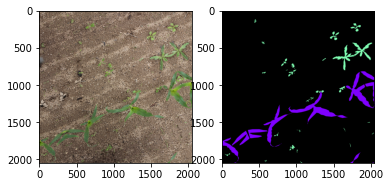

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

Here we define our custom architecture with encoder blocks composed by double convolutions with ReLu, batch normalization and dropout and decoder ones with transpose convolutions, better than standard bilinear upsamplings because they can learn weights.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


def unet_model(n_classes=3, n_filters_start=32, growth_factor=2, upconv=True):
    droprate=0.2
    n_filters = n_filters_start
    inputs = Input((img_h,img_w, 3))
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_0 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_0 = Dropout(droprate)(pool4_0)

    n_filters *= growth_factor
    pool4_0 = BatchNormalization()(pool4_0)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_0)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_1 = Dropout(droprate)(pool4_1)
    
    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv4_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv4_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    up9 = BatchNormalization()(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

In [ ]:
model = unet_model(n_classes=3, n_filters_start=32, growth_factor=2, upconv=True)

# Visualize created model as a table
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 2048,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 2048, 2048, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2048, 2048, 3 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 1024, 1024, 3 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

We tried to use a weighted version of the categorical corssentropy but we have achived worst resutls, so we don't use it in our next notebooks.

In [ ]:
weights = np.array([1,50,500])

from keras import backend as K
def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        one_hot_map = []
        for colour in range(0,3):
            class_map = tf.reduce_all(tf.equal(y_true, colour), axis=-1)
            one_hot_map.append(class_map)
        one_hot_map = tf.stack(one_hot_map, axis=-1)
        one_hot_map = tf.cast(one_hot_map, tf.float32)
        loss = one_hot_map * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


We define the meanIoU and compile the model

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# loss=weighted_categorical_crossentropy(weights)
# learning rate
lr = 1e-3   # After some trials, we have found this lr to be good enough to train quickly 
            # without oscillating too much around the final solution
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class 
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

We add some callbacks: model check points, early stopping to stop overfit and the learning rate adapter to refine search for minima during training. Then we train the model. (Normally it stops much before 80 epochs)

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/', 'segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)



# earlystopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', mode='max', patience=10,restore_best_weights=True)
callbacks.append(es_callback)
# learning rate adapter callback
LR_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_meanIoU', mode='max', factor=0.2, patience=4, verbose=1, min_delta=0.0001, cooldown=0)
callbacks.append(LR_adapter_callback)
    
model.fit(x=train_dataset,
          epochs=80,  
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks,
          verbose = 1) #We like to monitor the accuracy during training live ()

Epoch 1/80
71/71 [==============================] - 300s 4s/step - loss: 0.1255 - accuracy: 0.9631 - meanIoU: 0.2427 - val_loss: 0.1727 - val_accuracy: 0.9582 - val_meanIoU: 0.1222
Epoch 2/80
71/71 [==============================] - 284s 4s/step - loss: 0.0514 - accuracy: 0.9784 - meanIoU: 0.3084 - val_loss: 0.0564 - val_accuracy: 0.9818 - val_meanIoU: 0.3618
Epoch 3/80
71/71 [==============================] - 286s 4s/step - loss: 0.0490 - accuracy: 0.9799 - meanIoU: 0.3702 - val_loss: 0.0741 - val_accuracy: 0.9656 - val_meanIoU: 0.1992
Epoch 4/80
71/71 [==============================] - 276s 4s/step - loss: 0.0487 - accuracy: 0.9799 - meanIoU: 0.3641 - val_loss: 0.0624 - val_accuracy: 0.9821 - val_meanIoU: 0.3842
Epoch 5/80
71/71 [==============================] - 267s 4s/step - loss: 0.0457 - accuracy: 0.9813 - meanIoU: 0.4054 - val_loss: 0.0605 - val_accuracy: 0.9779 - val_meanIoU: 0.3562
Epoch 6/80
71/71 [==============================] - 288s 4s/step - loss: 0.0453 - accuracy: 0.9

Now we make predictions on the test set and we create a json file with the results.

In [ ]:
import os
import json
from os import listdir
import numpy as np
from PIL import Image


def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

submission_dict = {}

teams = ['Roseau','Bipbip','Pead','Weedelec']
plants = ['Haricot','Mais']

for team in teams:
  for plant in plants:
    test_dir = os.path.join('/content/Development_Dataset/Test_Dev', team, plant)
    img_folder_dir = os.path.join(test_dir, 'Images')
    imgs = listdir(img_folder_dir)
    imgs = [f[:-4] for f in imgs]
    for img_name in imgs:
      if team == 'Roseau':
        img = Image.open(os.path.join(test_dir, 'Images', img_name + '.png')).convert('RGB')
      else:
        img = Image.open(os.path.join(test_dir, 'Images', img_name + '.jpg')).convert('RGB')
      original_size=img.size
      img = img.resize((img_h, img_w))
      img_array = np.array(img)

      out_sigmoid = model.predict(tf.expand_dims(img_array, axis=0))
      mask_arr = tf.argmax(out_sigmoid, -1) 

      mask_arr=tf.reshape(mask_arr,[1,img_h,img_w,1])
      mask_arr=tf.compat.v1.image.resize_nearest_neighbor(mask_arr,original_size[::-1])
      mask_array=np.array(mask_arr)
      mask_array=np.reshape(mask_array,original_size[::-1])
      
      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = mask_array.shape
      submission_dict[img_name]['team'] = team  
      submission_dict[img_name]['crop'] = plant 
      submission_dict[img_name]['segmentation'] = {}

      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(mask_array == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_array == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

# Finally, save the results into the submission.json file
with open('/content/drive/My Drive/submission.json', 'w') as f:
    json.dump(submission_dict, f)

With this code we inspect also visually the goodnes of our predictions.

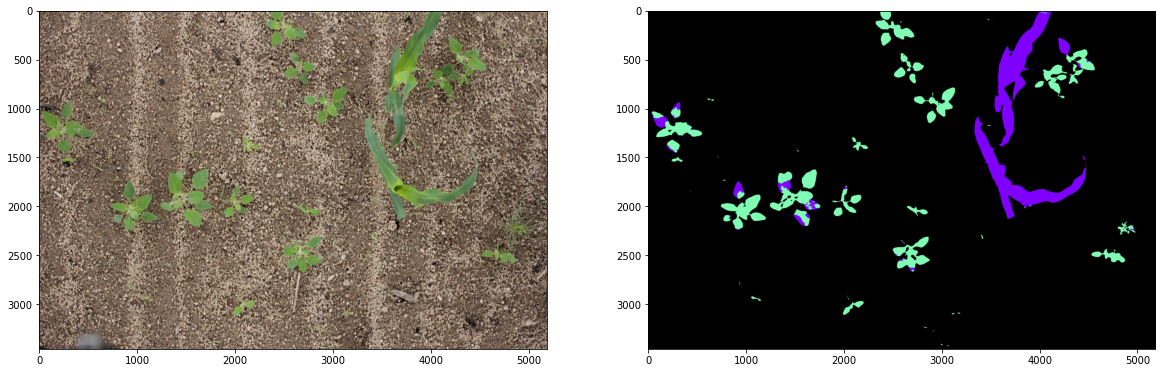

In [ ]:
# To visualize the output 
import os
import json
from os import listdir
import numpy as np
from PIL import Image

teams = 'Weedelec'
plants = 'Mais'


test_dir = os.path.join('/content/Development_Dataset/Test_Dev', teams, plants)
img_folder_dir = os.path.join(test_dir, 'Images')
imgs = listdir(img_folder_dir)
imgs = [f[:-4] for f in imgs]
img_name = imgs[3]  #here changing this index we look at the predictions of different images in the testset
if teams == 'Roseau':
  img = Image.open(os.path.join(test_dir, 'Images', img_name + '.png')).convert('RGB')
else:
  img = Image.open(os.path.join(test_dir, 'Images', img_name + '.jpg')).convert('RGB')
original_size=img.size
img1 = img.resize((img_h, img_w))
img_array = np.array(img1)
out_sigmoid = model.predict(tf.expand_dims(img_array, axis=0))
mask_arr = tf.argmax(out_sigmoid, -1)
mask_arr=tf.reshape(mask_arr,[1,img_h,img_w,1])
mask_arr=tf.compat.v1.image.resize_nearest_neighbor(mask_arr, original_size[::-1])
mask_array=np.array(mask_arr)
mask_array=np.reshape(mask_array,original_size[::-1])
target_img = np.zeros([mask_array.shape[0], mask_array.shape[1], 3])

target_img[np.where(mask_array == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(mask_array == i)] = np.array(colors[i-1])[:3] * 255
fig, ax = plt.subplots(1, 2,figsize=(20, 10))
ax[0].imshow(np.uint8(np.array(img)))
ax[1].imshow(np.uint8(target_img))

plt.show()